<a href="https://colab.research.google.com/github/leonardobove/handwritten_digit_recognition/blob/python_model/python/mlp_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")


GPU: Tesla T4 is available.


In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [96]:
torch.manual_seed(1)

In [97]:
# Get training and testing datasets
import torchvision

batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

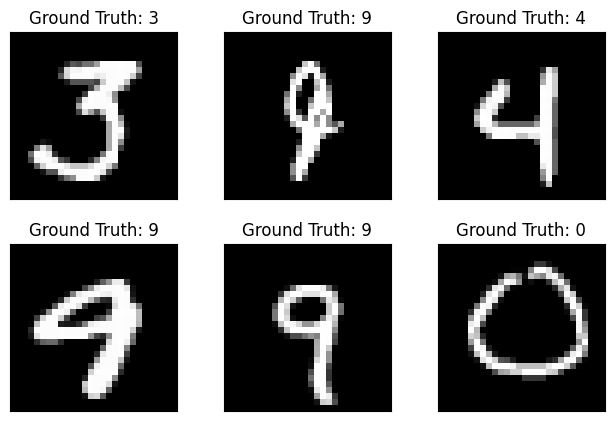

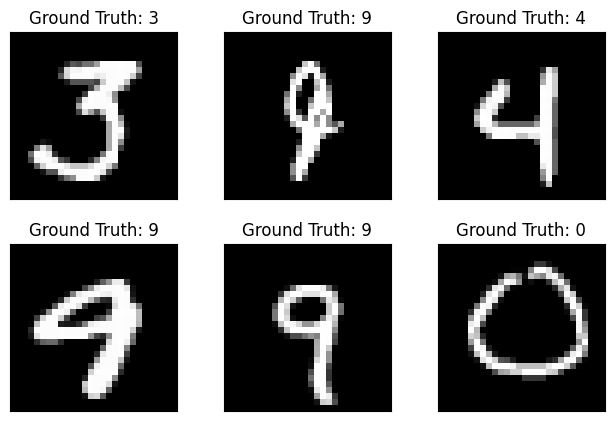

In [98]:
import matplotlib.pyplot as plt

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [99]:
import torch.nn.functional as F

print(train_loader.dataset.data.shape)
print(test_loader.dataset.data.shape)

# Edit targets so that they are a one-hot 1D tensor with shape (10)
#train_loader.dataset.targets = F.one_hot(train_loader.dataset.targets, num_classes=10).float()
#train_loader.dataset.targets = train_loader.dataset.targets.flip(dims=[1])

#test_loader.dataset.targets = F.one_hot(test_loader.dataset.targets, num_classes=10).float()
#test_loader.dataset.targets = test_loader.dataset.targets.flip(dims=[1])

print(train_loader.dataset.targets.shape)
print(test_loader.dataset.targets.shape)

# Move them to the GPU
train_loader.dataset.data.to('cuda')
train_loader.dataset.targets.to('cuda')
test_loader.dataset.data.to('cuda')
test_loader.dataset.targets.to('cuda')

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


tensor([7, 2, 1,  ..., 4, 5, 6], device='cuda:0')

In [100]:
import torch.nn as nn
import torch.optim as optim

# Create a
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_sigmoid_stack = nn.Sequential(
          nn.Linear(784, 30),
          nn.Sigmoid(),
          nn.Linear(30, 10),
          nn.Sigmoid()
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.linear_sigmoid_stack(x)

model = MLP() # Create a MLP instance

model = nn.DataParallel(model) # Wrap the model with DataParallel
model = model.to('cuda') # Move the model to the GPU

# Declare the loss function and the optimizer
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=3)

In [101]:
n_epochs = 3

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [102]:
!mkdir -p /results

In [103]:
log_interval = 10

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)

    # Edit targets so that they are a one-hot 1D tensor with shape (10).
    # E.g.: [2] => [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
    target = F.one_hot(target, num_classes=10).float()
    target = target.flip(dims=[1])
    target = target.to('cuda')

    # Evaluate error
    loss = loss_fn(output, target) # Mean square error

    # Propagate error and update the model parameters
    loss.backward()
    optimizer.step()

    # Training log
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(model.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
      for data, target in test_loader:
        output = model(data)
        # Edit targets so that they are a one-hot 1D tensor with shape (10).
        # E.g.: [2] => [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
        decimal_target = target # Save a copy in the original format
        decimal_target = decimal_target.to('cuda')
        target = F.one_hot(target, num_classes=10).float()
        target = target.flip(dims=[1])
        target = target.to('cuda')

        test_loss += loss_fn(output, target)
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(decimal_target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))

In [104]:
test() # Test without training

# Start training
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0003, Accuracy: 893/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.285515
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.088345
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.086934
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.084095
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.081911
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.075979
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.072069
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.067990
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.065317
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.065858
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.065172
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.059484
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.059565
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.050377
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.052483
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.052711
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.040420
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.043536
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.046571
Train Epoch: 1 [12160/6

In [111]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

AttributeError: 'list' object has no attribute 'device'

<Figure size 640x480 with 0 Axes>

In [ ]:
# If you have already trained the model previously, continue from here.
# Just load the learnt parameters and continue training the model

import torch.nn as nn
import torch.optim as optim

# Create a Sequential model with 2 layers
continued_model = nn.Sequential(
    nn.Linear(784, 30),
    nn.Sigmoid(),
    nn.Linear(30, 10),
    nn.Sigmoid()
)

continued_model = nn.DataParallel(model) # Wrap the model with DataParallel
continued_model = continued_model.to('cuda') # Move the model to the GPU

continued_optimizer = optim.SGD(model.parameters(), lr=3)

network_state_dict = torch.load()
continued_model.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load()
continued_optimizer.load_state_dict(optimizer_state_dict)

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig